In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from PIL import Image

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet121
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive

In [2]:
drive.mount('/content/drive')

train_path = '/content/drive/MyDrive/huh/train'
valid_path = '/content/drive/MyDrive/huh/val'

Mounted at /content/drive


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_aug.flow_from_directory(
    valid_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [11]:
def build_radimagenet(input_shape=(224, 224, 3), num_classes=5):
    base = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    base.load_weights('/content/drive/MyDrive/RadImageNet-ResNet50_notop.h5')

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=base.input, outputs=predictions)


In [5]:
def build_efficientnet(input_shape=(224, 224, 3), num_classes=5):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = BatchNormalization(axis = -1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l2=0.001),activity_regularizer=regularizers.l1(l1=0.006),
                bias_regularizer=regularizers.l1(l1=0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(num_classes, activation='softmax')(x)
    return models.Model(base.input, output)


In [6]:
def build_chexnet(input_shape=(224, 224, 3), num_classes=5):
    base_model = DenseNet121(include_top=False, weights=None, input_shape=input_shape)
    base_model.load_weights('/content/drive/MyDrive/brucechou1983_CheXNet_Keras_0.3.0_weights.h5', by_name=True, skip_mismatch=True)

    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
def compile_and_train(model, train_gen, val_gen, name):
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early = EarlyStopping(patience=3, restore_best_weights=True)

    checkpoint_cb = ModelCheckpoint(
        filepath=f'{name}_best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        save_weights_only=False,
        verbose=1
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[early, checkpoint_cb]
    )

    model.save(f'{name}_model.h5')
    return history


In [12]:
radimagenet = build_radimagenet()
radimagenet_hist = compile_and_train(radimagenet, train_gen, val_gen, 'radimagenet')

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3717 - loss: 1.4549 
Epoch 1: val_accuracy improved from -inf to 0.43705, saving model to radimagenet_best_model.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 2428s 13s/step - accuracy: 0.3719 - loss: 1.4545 - val_accuracy: 0.4370 - val_loss: 1.3125
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.4835 - loss: 1.2260
Epoch 2: val_accuracy improved from 0.43705 to 0.49758, saving model to radimagenet_best_model.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 106s 587ms/step - accuracy: 0.4835 - loss: 1.2258 - val_accuracy: 0.4976 - val_loss: 1.2069
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.5406 - loss: 1.1100
Epoch 3: val_accuracy did not improve from 0.49758
181/181 ━━━━━━━━━━━━━━━━━━━━ 105s 574ms/step - accuracy: 0.5406 - loss: 1.1098 - val_accuracy: 0.4891 - val_loss: 1.2199
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.5711 - loss: 1.0252
Epoch 4: val_accuracy improved from 0.49758 to 0.57385, saving model to radimagenet_best_model.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 106s 587ms/step - accuracy: 0.5711 - loss: 1.0251 - val_accuracy: 0.5738 - val_loss: 1.0395
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.5863 - loss: 0.9755
Epoch 5: val_accuracy did not improve from 0.57385
181/181 ━━━━━━━━━━━━━━━━━━━━ 141s 583ms/step - accuracy: 0.5864 - loss: 0.9754 - val_accuracy: 0.5351 - val_loss: 1.1021
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6147 - loss: 0.9315
Epoch 6: val_accuracy did not improve from 0.57385
181/181 ━━━━━━━━━━━━━━━━━━━━ 106s 586ms/step - accuracy: 0.6147 - loss: 0.9315 - val_accuracy: 0.5521 - val_loss: 1.0553
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.6317 - loss: 0.8910
Epoch 7: val_accuracy improved from 0.57385 to 0.59927, saving model to radimagenet_best_model.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 107s 590ms/step - accuracy: 0.6317 - loss: 0.8911 - val_accuracy: 0.5993 - val_loss: 0.9568
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.6348 - loss: 0.8730
Epoch 8: val_accuracy did not improve from 0.59927
181/181 ━━━━━━━━━━━━━━━━━━━━ 105s 577ms/step - accuracy: 0.6347 - loss: 0.8730 - val_accuracy: 0.5944 - val_loss: 1.0035
Epoch 9/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.6339 - loss: 0.8524
Epoch 9: val_accuracy did not improve from 0.59927
181/181 ━━━━━━━━━━━━━━━━━━━━ 105s 581ms/step - accuracy: 0.6340 - loss: 0.8524 - val_accuracy: 0.5266 - val_loss: 1.1986
Epoch 10/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.6489 - loss: 0.8518
Epoch 10: val_accuracy did not improve from 0.59927
181/181 ━━━━━━━━━━━━━━━━━━━━ 145s 597ms/step - accuracy: 0.6489 - loss: 0.8517 - val_accuracy: 0.5678 - val_loss: 1.0285


In [ ]:
# efficientnet = build_efficientnet()
# efficientnet_hist = compile_and_train(efficientnet, train_gen, val_gen, 'efficientnet')

In [ ]:
# chexnet = build_chexnet()
# chexnet_hist = compile_and_train(chexnet, train_gen, val_gen, 'chexnet')

In [13]:
print("Train class indices:", train_gen.class_indices)
print("Validation class indices:", val_gen.class_indices)

Train class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
Validation class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


In [14]:
def plot_history(history_dict):
    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for name, hist in history_dict.items():
        plt.plot(hist.history['accuracy'], label=f'{name} Train')
        plt.plot(hist.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for name, hist in history_dict.items():
        plt.plot(hist.history['loss'], label=f'{name} Train')
        plt.plot(hist.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
import matplotlib.pyplot as plt

def plot_all_model_histories(history_dict, val = False):
    """
    Plots training and validation accuracy/loss for multiple models on a single plot.

    Parameters:
    - history_dict: Dictionary of model_name -> history object from model.fit()
    """

    plt.figure(figsize=(16, 6))

    # ----------------- ACCURACY ----------------- #
    plt.subplot(1, 2, 1)
    for model_name, hist in history_dict.items():
        if val:
          plt.plot(hist.history['val_accuracy'], linestyle='--', label=f'{model_name} - Val')
          plt.title('Validation Accuracy')
        else:
          plt.plot(hist.history['accuracy'], label=f'{model_name} - Train')
          plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # ----------------- LOSS ----------------- #
    plt.subplot(1, 2, 2)
    for model_name, hist in history_dict.items():
        if val:
            plt.plot(hist.history['val_loss'], linestyle='--', label=f'{model_name} - Val')
            plt.title('Validation Loss')
        else:
            plt.plot(hist.history['loss'], label=f'{model_name} - Train')
            plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.suptitle("Model Training Comparison", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
history_dict = {
    'RadImageNet': radimagenet_hist
    # 'CheXNet': chexnet_hist,
    # 'EfficientNet': efficientnet_hist
}

In [ ]:
# plot_all_model_histories(history_dict, val=True)

In [17]:
train_path2 = '/content/drive/MyDrive/images/training'
valid_path2 = '/content/drive/MyDrive/images/valid'

In [18]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_aug = ImageDataGenerator(rescale=1./255)

train_gen2 = train_aug.flow_from_directory(
    train_path2,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen2 = val_aug.flow_from_directory(
    valid_path2,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1750 images belonging to 3 classes.
Found 305 images belonging to 3 classes.


In [19]:
radimagenet2 = build_radimagenet(num_classes=3)
radimagenet_hist2 = compile_and_train(radimagenet2, train_gen2, val_gen2, 'radimagenet3class')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4400 - loss: 1.0573
Epoch 1: val_accuracy improved from -inf to 0.38361, saving model to radimagenet3class_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 606s 10s/step - accuracy: 0.4408 - loss: 1.0566 - val_accuracy: 0.3836 - val_loss: 1.0926
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.5999 - loss: 0.8433
Epoch 2: val_accuracy improved from 0.38361 to 0.56721, saving model to radimagenet3class_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 612ms/step - accuracy: 0.6006 - loss: 0.8422 - val_accuracy: 0.5672 - val_loss: 0.8360
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7449 - loss: 0.6104
Epoch 3: val_accuracy did not improve from 0.56721
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 579ms/step - accuracy: 0.7449 - loss: 0.6102 - val_accuracy: 0.5049 - val_loss: 1.3154
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7959 - loss: 0.5236
Epoch 4: val_accuracy improved from 0.56721 to 0.72131, saving model to radimagenet3class_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - accuracy: 0.7958 - loss: 0.5235 - val_accuracy: 0.7213 - val_loss: 0.6111
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.7969 - loss: 0.5049
Epoch 5: val_accuracy improved from 0.72131 to 0.78033, saving model to radimagenet3class_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 604ms/step - accuracy: 0.7971 - loss: 0.5042 - val_accuracy: 0.7803 - val_loss: 0.5629
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8192 - loss: 0.4166
Epoch 6: val_accuracy improved from 0.78033 to 0.81311, saving model to radimagenet3class_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 632ms/step - accuracy: 0.8193 - loss: 0.4166 - val_accuracy: 0.8131 - val_loss: 0.4310
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8478 - loss: 0.3676
Epoch 7: val_accuracy did not improve from 0.81311
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 604ms/step - accuracy: 0.8477 - loss: 0.3677 - val_accuracy: 0.6656 - val_loss: 0.7194
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8531 - loss: 0.3673
Epoch 8: val_accuracy did not improve from 0.81311
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 597ms/step - accuracy: 0.8532 - loss: 0.3673 - val_accuracy: 0.7705 - val_loss: 0.6359
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8798 - loss: 0.3184
Epoch 9: val_accuracy did not improve from 0.81311
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 580ms/step - accuracy: 0.8797 - loss: 0.3188 - val_accuracy: 0.6197 - val_loss: 1.0062


In [20]:
history_dict = {
    'RadImageNet - 5 classes': radimagenet_hist,
    'RadImageNet - 3 classes': radimagenet_hist2
    # 'EfficientNet': efficientnet_hist
}

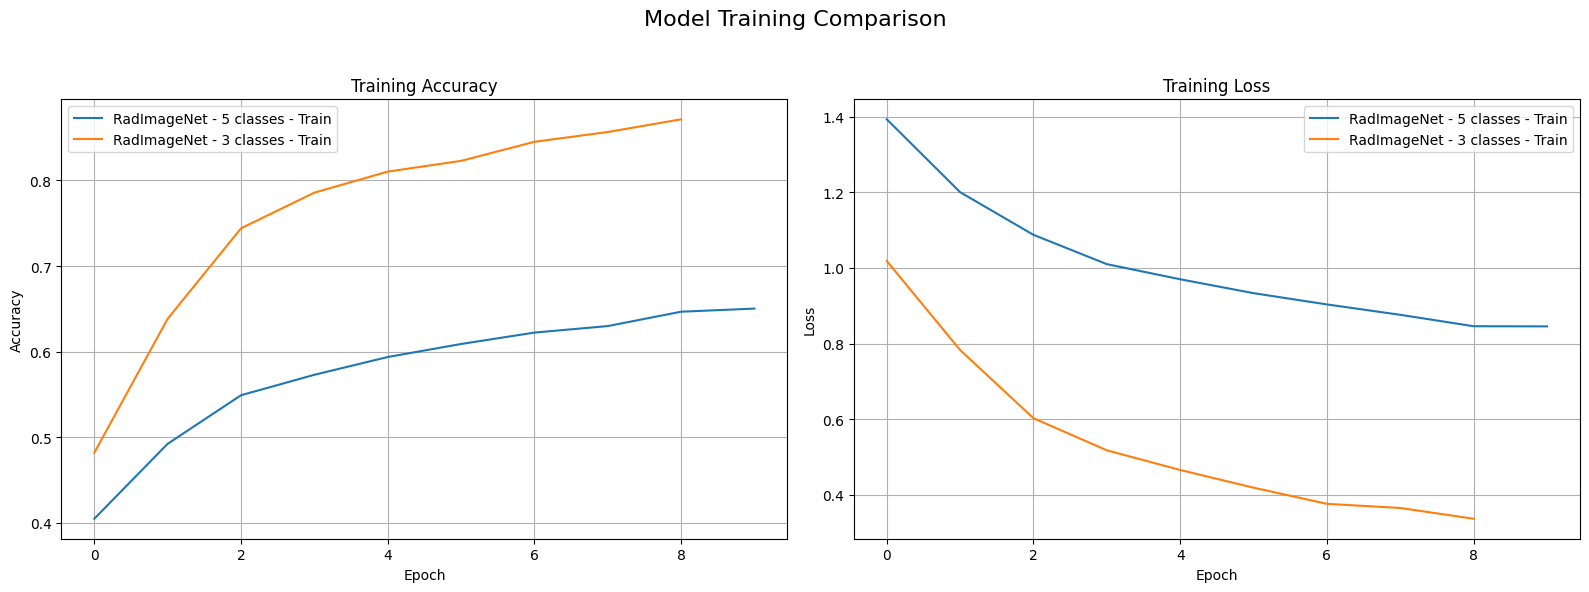

In [21]:
plot_all_model_histories(history_dict, val=False)

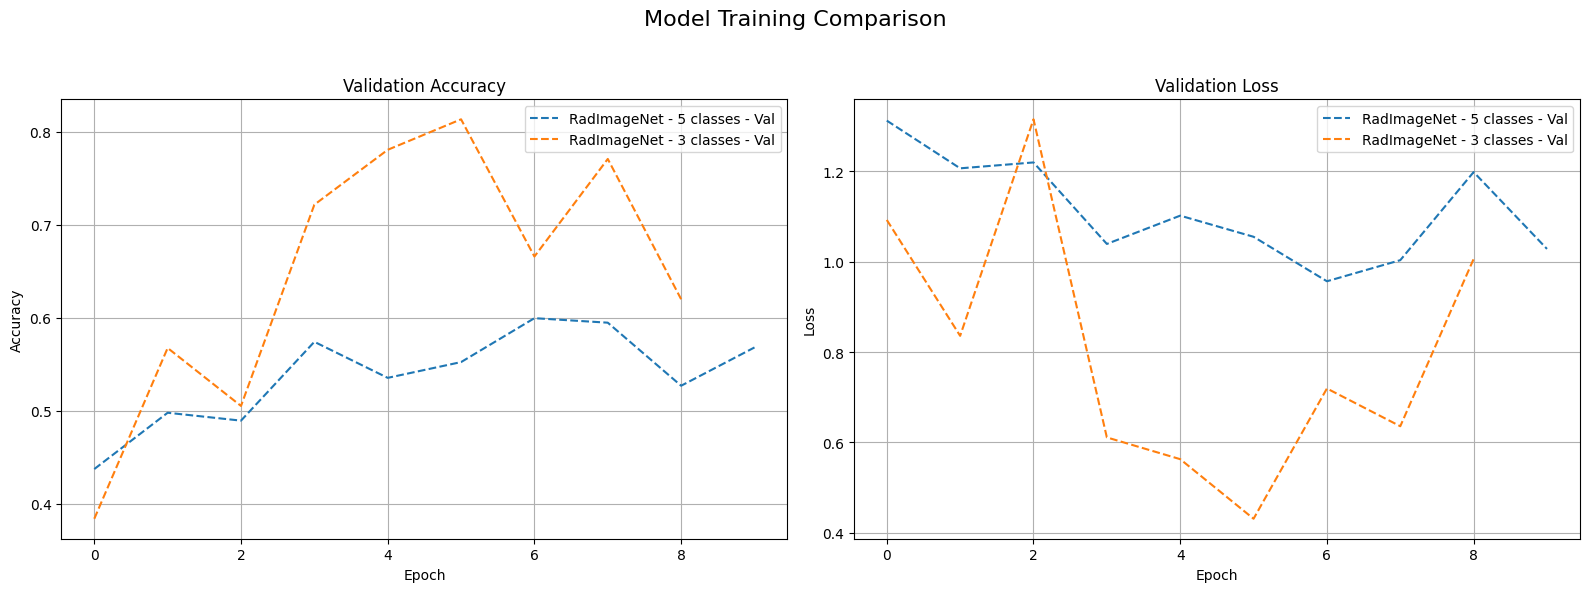

In [22]:
plot_all_model_histories(history_dict, val=True)